In [77]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense, LeakyReLU
from sklearn.model_selection import cross_val_score


# 데이터셋 로드

In [54]:
train_path = 'train/'
test_path =  'test/'

# 데이터 어그멘테이션

## train generator 생성

In [248]:
train_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=False,
                                     shear_range=0.22,
                                     zoom_range=0.22,
                                     rescale=1./255,
                                     validation_split=0.2)

test_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=False,
                                    rescale=1./255,)

# Training set
train_set = train_generator.flow_from_directory(train_path,
                                           batch_size=16,
                                           class_mode='binary',
                                           target_size=(96, 96),
                                           color_mode='rgb',
                                           shuffle=False,
                                           subset='training')
# Validation set
validation_set = train_generator.flow_from_directory(train_path,
                                           batch_size=16,
                                           class_mode='binary',
                                           target_size=(96, 96),
                                           color_mode='rgb',
                                           shuffle=False,
                                           subset='validation')

# Test set / no output available
test_set = test_generator.flow_from_directory(test_path,
                                         batch_size=16,
                                         class_mode='binary',
                                         target_size=(96, 96),
                                         color_mode='rgb',
                                         shuffle=False)

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Found 2041 images belonging to 2 classes.


## 콜백

In [249]:
early_stop= tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
#lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Good Performance Model Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (96, 96, 3), activation=LeakyReLU(alpha=0.15)))
model.add(MaxPool2D(pool_size=(2,2), strides=2)) #if stride not given it equal to pool filter size
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['accuracy'])
# 27 89 148 52

model = Sequential()
model.add(Conv2D(48, (3,3), input_shape = (96, 96, 3), activation=LeakyReLU(alpha=0.15)))
model.add(MaxPool2D(pool_size=(2,2), strides=2)) #if stride not given it equal to pool filter size
model.add(Conv2D(48, (3,3), activation = 'relu')) #Leaky is ok
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(units=192,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['accuracy'])
# Not bad

# 모델 설계 및 학습

In [ ]:
model = Sequential()
model.add(Conv2D(48, (3,3), input_shape = (96, 96, 3), activation=LeakyReLU(alpha=0.15)))
model.add(MaxPool2D(pool_size=(2,2), strides=2)) #if stride not given it equal to pool filter size

model.add(Conv2D(72, (3,3), activation = LeakyReLU(alpha=0.15)))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
#model.add(Conv2D(64, (3,3), activation = 'relu'))
#model.add(MaxPool2D(pool_size=(2,2), strides=2))

#model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=144,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
#adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#model.summary()

hist = model.fit(train_set,
               validation_data = validation_set,
               epochs=100,
               callbacks=[early_stop]);

# 그나마 괜찮은 구조.
#model.add(Conv2D(32, (3,3), input_shape = (96, 96, 3), activation=LeakyReLU(alpha=0.15)))
#model.add(MaxPool2D(pool_size=(2,2), strides=2)) #if stride not given it equal to pool filter size

#model.add(Conv2D(64, (3,3), activation = LeakyReLU(alpha=0.15)))
#model.add(MaxPool2D(pool_size=(2,2), strides=2))

Epoch 1/100
103/103 [==============================] - 25s 238ms/step - loss: 1.3513 - accuracy: 0.5181 - val_loss: 0.6929 - val_accuracy: 0.5294
Epoch 2/100
 17/103 [===>..........................] - ETA: 18s - loss: 0.6918 - accuracy: 0.6471

## 모델 확인

In [121]:
# 모델 저장
model.save('model.h5')

# 라벨 확인
print (test_set.class_indices)

# 모델 평가
score = model.evaluate(validation_set, verbose=1)
print (score)

# 모델 예측
predict = model.predict(test_set, verbose=1)
print (len(predict))

{'training_fake': 0, 'training_real': 1}
13/13 [==============================] - 3s 206ms/step - loss: 0.7047 - accuracy: 0.5392
[0.7047401666641235, 0.5392156839370728]
64/64 [==============================] - 11s 165ms/step
2041


# 시각화

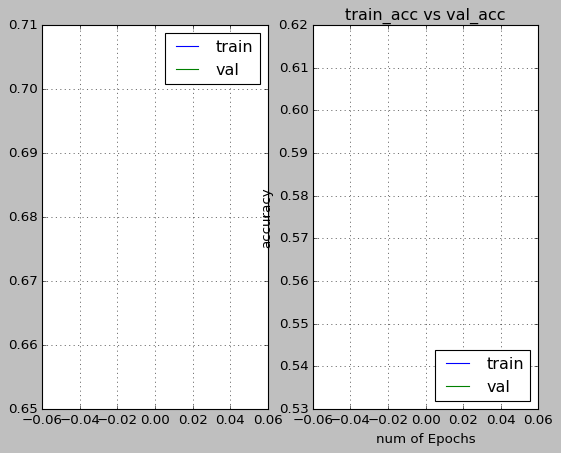

In [123]:
import matplotlib.pyplot as plt

epochs = 1
xc = range(epochs)
fig, ax = plt.subplots(1, 2)
#ax[0].plot(hist.history['accuracy'], c='b', label='train acc')
#ax[0].plot(hist.history['val_accuracy'], c='r', label='val acc')
#ax[1].plot(hist.history['loss'], c='r', label='loss')
#ax[0].legend()
#ax[1].legend()
#plt.show()

ax[0].plot(xc, hist.history['loss'])
ax[0].plot(xc, hist.history['val_loss'])
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('training loss vs val loss')
ax[0].grid(True)
ax[0].legend(['train', 'val'])
plt.style.use(['classic'])


#ax[1].figure(2,figsize=(7,5))
ax[1].plot(xc, hist.history['accuracy'])
ax[1].plot(xc,hist.history['val_accuracy'])
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
ax[1].grid(True)
ax[1].legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()


#epochs = 43
#train_loss = hist.history['loss']
#val_loss = hist.history['val_loss']
#train_acc = hist.history['accuracy']
#val_acc = hist.history['val_accuracy']
#xc = range(epochs)

#plt.figure(1,figsize=(7,5))
#plt.plot(xc,train_loss)
#plt.plot(xc,val_loss)
#plt.xlabel('num of Epochs')
#plt.ylabel('loss')
#plt.title('train_loss vs val_loss')
#plt.grid(True)
#plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

#plt.figure(2,figsize=(7,5))
#plt.plot(xc,train_acc)
#plt.plot(xc,val_acc)
#plt.xlabel('num of Epochs')
#plt.ylabel('accuracy')
#plt.title('train_acc vs val_acc')
#plt.grid(True)
#plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

In [124]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import cv2
size = (96, 96)

def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (96, 96))
    return image[..., ::-1]

fake_images = os.listdir('./test/training_fake/')

false_positive = 0
positive = 0

for i in fake_images:
    test_image = load_img('./test/training_fake/' + i )
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    result = model.predict(test_image)
    prediction = ["real" if result[0][0] == 1 else "fake"]
    if prediction[0] == "real":
        false_positive += 1
    else:
        positive += 0
        
    print (f"{i}: {prediction[0]}")


print (f"[*] False positive: {false_positive}")
print (f"[*] True positive: {positive}")

easy_100_1111.jpg: fake
easy_101_0010.jpg: fake
easy_102_0101.jpg: fake
easy_103_1111.jpg: real
easy_104_1000.jpg: fake
easy_105_1100.jpg: fake
easy_106_0011.jpg: fake
easy_107_1011.jpg: fake
easy_108_1111.jpg: fake
easy_109_1111.jpg: fake
easy_10_0001.jpg: real
easy_110_0001.jpg: fake
easy_111_1101.jpg: fake
easy_112_1001.jpg: real
easy_113_0011.jpg: real
easy_114_1110.jpg: fake
easy_115_0010.jpg: fake
easy_116_111.jpg: real
easy_117_0101.jpg: fake
easy_118_1111.jpg: fake
easy_119_0011.jpg: fake
easy_11_1111.jpg: fake
easy_120_0011.jpg: fake
easy_121_0011.jpg: fake
easy_122_1011.jpg: fake
easy_123_0100.jpg: fake
easy_124_1110.jpg: fake
easy_125_0011.jpg: fake
easy_126_0111.jpg: fake
easy_127_0001.jpg: fake
easy_128_0111.jpg: fake
easy_129_1111.jpg: fake
easy_12_1110.jpg: fake
easy_130_1101.jpg: fake
easy_131_1001.jpg: fake
easy_132_0110.jpg: fake
easy_133_1100.jpg: fake
easy_134_0001.jpg: fake
easy_135_0011.jpg: fake
easy_136_0111.jpg: fake
easy_137_0001.jpg: fake
easy_138_0101.jpg: f

hard_200_1111.jpg: fake
hard_201_0100.jpg: fake
hard_202_1101.jpg: real
hard_203_0010.jpg: fake
hard_204_0011.jpg: real
hard_205_0011.jpg: real
hard_206_0001.jpg: fake
hard_207_1100.jpg: fake
hard_208_0001.jpg: fake
hard_209_1011.jpg: fake
hard_20_1111.jpg: real
hard_210_1100.jpg: fake
hard_211_0110.jpg: fake
hard_212_1101.jpg: fake
hard_213_0101.jpg: fake
hard_214_1011.jpg: fake
hard_215_1101.jpg: fake
hard_216_0111.jpg: fake
hard_217_1100.jpg: fake
hard_218_0100.jpg: fake
hard_219_1101.jpg: fake
hard_21_1101.jpg: fake
hard_220_1111.jpg: fake
hard_221_0101.jpg: fake
hard_222_1001.jpg: fake
hard_223_1111.jpg: fake
hard_224_0111.jpg: fake
hard_225_0011.jpg: fake
hard_226_0100.jpg: fake
hard_227_1100.jpg: fake
hard_228_1111.jpg: real
hard_229_0100.jpg: fake
hard_22_1111.jpg: fake
hard_230_1110.jpg: fake
hard_231_1111.jpg: fake
hard_232_0001.jpg: fake
hard_233_0010.jpg: real
hard_234_1100.jpg: real
hard_235_0001.jpg: fake
hard_236_1001.jpg: fake
hard_237_0010.jpg: fake
hard_238_1000.jpg: 

mid_308_1111.jpg: fake
mid_309_1111.jpg: fake
mid_30_1110.jpg: fake
mid_310_0111.jpg: fake
mid_311_0011.jpg: fake
mid_312_1111.jpg: fake
mid_313_1101.jpg: real
mid_314_1101.jpg: fake
mid_315_1101.jpg: fake
mid_316_1111.jpg: fake
mid_317_1101.jpg: fake
mid_318_1111.jpg: fake
mid_319_1111.jpg: fake
mid_31_1111.jpg: fake
mid_320_1111.jpg: real
mid_321_1110.jpg: fake
mid_322_1111.jpg: fake
mid_323_1101.jpg: fake
mid_324_1111.jpg: fake
mid_325_0011.jpg: fake
mid_326_1111.jpg: fake
mid_327_0111.jpg: fake
mid_328_0011.jpg: real
mid_329_1110.jpg: real
mid_32_1111.jpg: fake
mid_330_1111.jpg: fake
mid_331_0011.jpg: fake
mid_332_1111.jpg: real
mid_333_1101.jpg: fake
mid_334_1111.jpg: fake
mid_335_1100.jpg: fake
mid_336_1111.jpg: fake
mid_337_1111.jpg: fake
mid_338_1100.jpg: real
mid_339_1100.jpg: fake
mid_33_1011.jpg: fake
mid_340_1111.jpg: fake
mid_341_1110.jpg: fake
mid_342_1110.jpg: fake
mid_343_1111.jpg: real
mid_344_0010.jpg: fake
mid_345_1111.jpg: fake
mid_346_0011.jpg: fake
mid_347_0011.jp

In [125]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt


fake_images = os.listdir('./test/training_fake/')
false_positive = 0
positive = 0

for i in fake_images:
    img1 = image.load_img('./test/training_fake/' + i, target_size=(96, 96))
    img = image.img_to_array(img1)
    img = img/255
    # create a batch of size 1 [N,H,W,C]
    img = np.expand_dims(img, axis=0)
    prediction = model2.predict(img, batch_size=None, steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
        value ='Real :%1.2f'%(prediction[0,0])
        plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
        print (i + ": real")
    else:
        value ='Fake :%1.2f'%(1.0-prediction[0,0])
        #plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
        print (i + ": fake")

    #plt.imshow(img1)
    #plt.show()

easy_100_1111.jpg: real
easy_101_0010.jpg: fake
easy_102_0101.jpg: real
easy_103_1111.jpg: real
easy_104_1000.jpg: fake
easy_105_1100.jpg: fake
easy_106_0011.jpg: fake
easy_107_1011.jpg: fake
easy_108_1111.jpg: real
easy_109_1111.jpg: fake
easy_10_0001.jpg: fake
easy_110_0001.jpg: fake
easy_111_1101.jpg: fake
easy_112_1001.jpg: real
easy_113_0011.jpg: fake
easy_114_1110.jpg: fake
easy_115_0010.jpg: fake
easy_116_111.jpg: fake
easy_117_0101.jpg: fake
easy_118_1111.jpg: fake
easy_119_0011.jpg: real
easy_11_1111.jpg: real
easy_120_0011.jpg: fake
easy_121_0011.jpg: fake
easy_122_1011.jpg: fake
easy_123_0100.jpg: real
easy_124_1110.jpg: fake
easy_125_0011.jpg: fake
easy_126_0111.jpg: real
easy_127_0001.jpg: fake
easy_128_0111.jpg: fake
easy_129_1111.jpg: fake
easy_12_1110.jpg: fake
easy_130_1101.jpg: fake
easy_131_1001.jpg: fake
easy_132_0110.jpg: real
easy_133_1100.jpg: real
easy_134_0001.jpg: fake
easy_135_0011.jpg: fake
easy_136_0111.jpg: fake
easy_137_0001.jpg: fake
easy_138_0101.jpg: f

hard_203_0010.jpg: fake
hard_204_0011.jpg: real
hard_205_0011.jpg: fake
hard_206_0001.jpg: fake
hard_207_1100.jpg: fake
hard_208_0001.jpg: fake
hard_209_1011.jpg: fake
hard_20_1111.jpg: fake
hard_210_1100.jpg: fake
hard_211_0110.jpg: fake
hard_212_1101.jpg: fake
hard_213_0101.jpg: fake
hard_214_1011.jpg: fake
hard_215_1101.jpg: fake
hard_216_0111.jpg: fake
hard_217_1100.jpg: fake
hard_218_0100.jpg: fake
hard_219_1101.jpg: fake
hard_21_1101.jpg: fake
hard_220_1111.jpg: fake
hard_221_0101.jpg: fake
hard_222_1001.jpg: fake
hard_223_1111.jpg: fake
hard_224_0111.jpg: fake
hard_225_0011.jpg: fake
hard_226_0100.jpg: fake
hard_227_1100.jpg: fake
hard_228_1111.jpg: fake
hard_229_0100.jpg: fake
hard_22_1111.jpg: fake
hard_230_1110.jpg: fake
hard_231_1111.jpg: fake
hard_232_0001.jpg: fake
hard_233_0010.jpg: fake
hard_234_1100.jpg: fake
hard_235_0001.jpg: fake
hard_236_1001.jpg: fake
hard_237_0010.jpg: fake
hard_238_1000.jpg: fake
hard_239_1000.jpg: fake
hard_23_1110.jpg: fake
hard_240_1101.jpg: f

mid_311_0011.jpg: fake
mid_312_1111.jpg: fake
mid_313_1101.jpg: fake
mid_314_1101.jpg: fake
mid_315_1101.jpg: fake
mid_316_1111.jpg: fake
mid_317_1101.jpg: fake
mid_318_1111.jpg: fake
mid_319_1111.jpg: fake
mid_31_1111.jpg: fake
mid_320_1111.jpg: fake
mid_321_1110.jpg: fake
mid_322_1111.jpg: fake
mid_323_1101.jpg: fake
mid_324_1111.jpg: fake
mid_325_0011.jpg: fake
mid_326_1111.jpg: fake
mid_327_0111.jpg: fake
mid_328_0011.jpg: fake
mid_329_1110.jpg: fake
mid_32_1111.jpg: fake
mid_330_1111.jpg: fake
mid_331_0011.jpg: fake
mid_332_1111.jpg: fake
mid_333_1101.jpg: fake
mid_334_1111.jpg: fake
mid_335_1100.jpg: fake
mid_336_1111.jpg: fake
mid_337_1111.jpg: fake
mid_338_1100.jpg: fake
mid_339_1100.jpg: fake
mid_33_1011.jpg: fake
mid_340_1111.jpg: fake
mid_341_1110.jpg: fake
mid_342_1110.jpg: fake
mid_343_1111.jpg: fake
mid_344_0010.jpg: fake
mid_345_1111.jpg: fake
mid_346_0011.jpg: fake
mid_347_0011.jpg: fake
mid_348_1100.jpg: fake
mid_349_1111.jpg: fake
mid_34_1111.jpg: fake
mid_350_0100.jp